# Aave Safety Module - Slashing Percentage

This notebook generates the curves for modeling the insurance power and capital efficiency of the safety module with respect to the lashing percentage.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [2]:
def get_new_R(R1, p1, p2, r_0, r_other, r_slash):
    return R1 * p1 / p2 * (r_0 + r_other + p2 * r_slash) / (r_0 + r_other + p1* r_slash)

def get_r_slash(apr, r_0, r_other, p):
    return (apr - r_0 - r_other) / p

def get_apr(r_0, r_other, r_slash, p):
    return r_0 + r_other + p*r_slash

def get_insurance(R, r_0, r_other, r_slash, p): 
    return p*R/(r_0 + r_other + p*r_slash)

def get_tvl(apr, R):
    return R / apr

def get_savings(r_0, r_other, r_slash, p1, p2, R1):
    R2 = get_new_R(R1, p1, p2, r_0, r_other, r_slash)
    return R1 - R2

In [3]:
p1 = 0.3
p2 = 1

# As of June 29th 2023
R1 = 1_100 * 365 / 2
OLD_APR = 0.0613
p_AAVE = 72

r_0 = 0.02 # roughly USDC staking APR
r_other = 0 # Let's say it's negligible
r_slash = get_r_slash(OLD_APR, r_0, r_other, p1)
print(f'Slashing Premium: {r_slash:.2%}')

Slashing Premium: 13.77%


# Calculate New Insurance Power while Keeping Emissions Constant

AAVE pool at p = 0.3
Insurance Power: 70.74 (Mns USD)
TVL: 235.79 (Mns USD)
APR: 6.13%

AAVE pool at p = 1
Insurance Power: 91.67 (Mns USD)
TVL: 91.67 (Mns USD)
APR: 15.77%


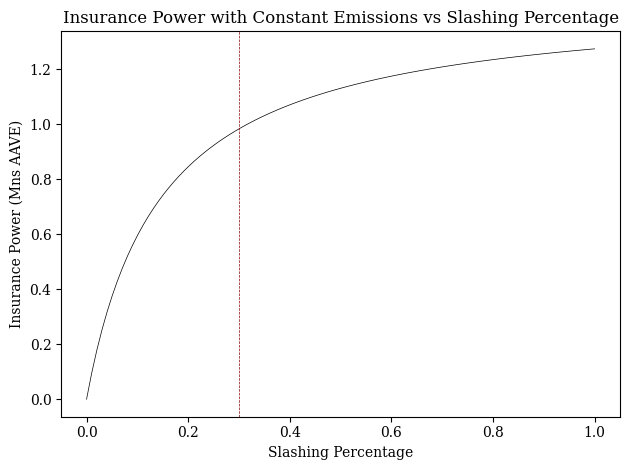

In [4]:
OLD_INSURANCE_POWER = get_insurance(R1, r_0, r_other, r_slash, p1)
OLD_TVL = get_tvl(OLD_APR, R1)
print(f'AAVE pool at p = 0.3\nInsurance Power: {OLD_INSURANCE_POWER*p_AAVE/1e6:.2f} (Mns USD)\nTVL: {OLD_TVL*p_AAVE/1e6:.2f} (Mns USD)\nAPR: {OLD_APR:.2%}')
print()
NEW_INSURANCE_POWER = get_insurance(R1, r_0, r_other, r_slash, p2)
NEW_APR = get_apr(r_0, r_other, r_slash, p2)
NEW_TVL = get_tvl(NEW_APR, R1)
print(f'AAVE pool at p = 1\nInsurance Power: {NEW_INSURANCE_POWER*p_AAVE/1e6:.2f} (Mns USD)\nTVL: {NEW_TVL*p_AAVE/1e6:.2f} (Mns USD)\nAPR: {NEW_APR:.2%}')

x = np.linspace(0, 1, 100)
y = np.ones(len(x))
for i, xi in enumerate(x):
    y[i] = get_insurance(R1, r_0, r_other, r_slash, xi) / 1e6

f, ax = plt.subplots()

ax.plot(x, y, linewidth=0.5, color='black')
ax.set_xlabel('Slashing Percentage')
ax.set_ylabel('Insurance Power (Mns AAVE)')
ax.set_title('Insurance Power with Constant Emissions vs Slashing Percentage')

ax.axvline(0.3, color='darkred', linestyle='--', linewidth=0.5)

f.tight_layout()
f.savefig('./figs/insurance_power.png', bbox_inches='tight')

In [5]:
# Annual Savings
R2 = get_new_R(R1, p1, p2, r_0, r_other, r_slash)
AAVE_savings = get_savings(r_0, r_other, r_slash, p1, p2, R1)
dollar_savings = AAVE_savings * p_AAVE

print(f'Annual Savings: {format(AAVE_savings, ",.2f")} AAVE')
print(f'Annual Savings: ${format(dollar_savings, ",.2f")}')

Annual Savings: 45,848.29 AAVE
Annual Savings: $3,301,076.67


In [6]:
# Get new APR
LOW_EMISSIONS_APR = get_apr(r_0, r_other, r_slash, p2)
LOW_EMISSIONS_TVL = get_tvl(LOW_EMISSIONS_APR, R2)
LOW_EMISSIONS_INSURANCE = get_insurance(R2, r_0, r_other, r_slash, p2)
print(f'New APR: {LOW_EMISSIONS_APR:.2%}')
print(f'New TVL: {LOW_EMISSIONS_TVL*p_AAVE/1e6:.2f} (Mns USD)')
print(f'New Insurance Power: {LOW_EMISSIONS_INSURANCE*p_AAVE/1e6:.2f} (Mns USD)')
print(f'New Emissions Required: {R2:,.2f} AAVE')

New APR: 15.77%
New TVL: 70.74 (Mns USD)
New Insurance Power: 70.74 (Mns USD)
New Emissions Required: 154,901.71 AAVE


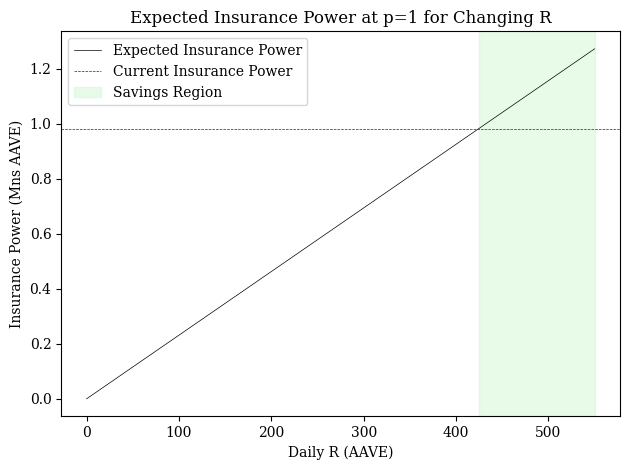

In [7]:
x = np.linspace(1, R1, 1000)
y = np.ones(len(x))
for i, xi in enumerate(x):
    y[i] = get_insurance(xi, r_0, r_other, r_slash, p2)/1e6
x /= 365

f, ax = plt.subplots()

ax.plot(x, y, linewidth=0.5, color='black', label='Expected Insurance Power')
ax.axhline(OLD_INSURANCE_POWER/1e6, color='darkred', linestyle='--', linewidth=0.5, label="Current Insurance Power")
ax.axvspan(R1/365, R2/365, color='lightgreen', alpha=0.2, label='Savings Region')

ax.set_xlabel('Daily R (AAVE)')
ax.set_ylabel('Insurance Power (Mns AAVE)')
ax.set_title('Expected Insurance Power at p=1 for Changing R')
ax.legend()

f.tight_layout()
f.savefig('./figs/possible_savings.png', bbox_inches='tight')

# Sensitivity Analysis
Let's look at historical AAVE prices, safety module APRs, and USDC deposit rates (our risk-free rate proxy) to determine how our capital inefficiency estimate changes over time.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-30,59.672035,59.998501,53.469746,56.969864,56.969864,136807787
2022-07-01,57.060410,58.887405,55.099827,56.146023,56.146023,128961935
2022-07-02,56.177555,58.319584,55.003292,57.834541,57.834541,108387906
2022-07-03,57.842422,58.345417,54.939720,57.618336,57.618336,95602594
2022-07-04,57.616795,63.106419,56.409195,63.060158,63.060158,147687621


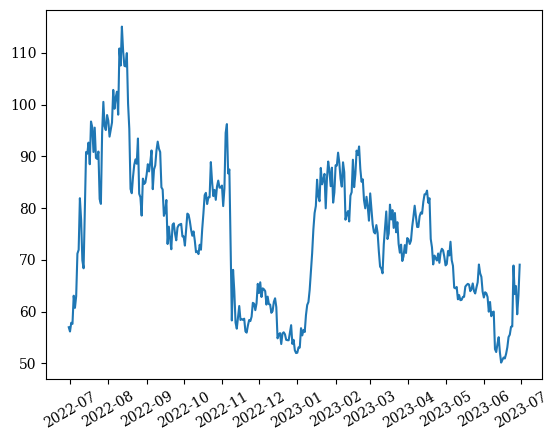

In [8]:
AAVE_prices = pd.read_csv('./data/price.csv', index_col='Date')
AAVE_prices.index = pd.to_datetime(AAVE_prices.index)
display(AAVE_prices.head())
plt.plot(AAVE_prices.index, AAVE_prices['Close'])
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set the locator to show ticks at monthly intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)  # Rotate and align the tick labels

,ADDRESS,BALANCE,DECIMALS,NAME
DATETIME,,,,
2023-06-30,0x4da27a545c0c5b758a6ba100e3a049001de870f5,3.272340e+06,18.0,Staked Aave
2023-06-29,0x4da27a545c0c5b758a6ba100e3a049001de870f5,3.089534e+06,18.0,Staked Aave
2023-06-28,0x4da27a545c0c5b758a6ba100e3a049001de870f5,3.269795e+06,18.0,Staked Aave
2023-06-27,0x4da27a545c0c5b758a6ba100e3a049001de870f5,3.267601e+06,18.0,Staked Aave
2023-06-26,0x4da27a545c0c5b758a6ba100e3a049001de870f5,3.206736e+06,18.0,Staked Aave


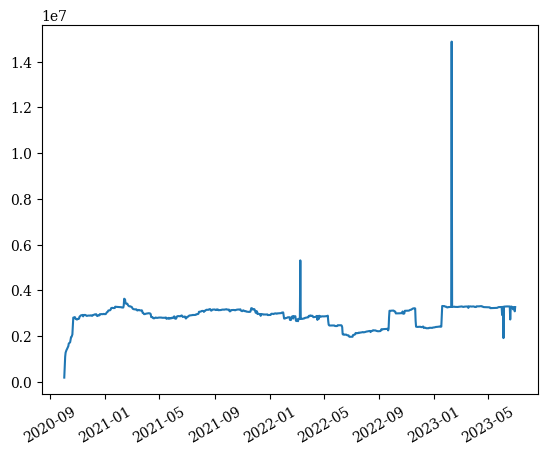

In [9]:
stkAAVE_supply = pd.read_csv('./data/stkAAAVE_supply.csv', index_col='DATETIME').dropna()
stkAAVE_supply.index = pd.to_datetime(stkAAVE_supply.index)
display(stkAAVE_supply.head())
plt.plot(stkAAVE_supply.index, stkAAVE_supply['BALANCE'])
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)  # Rotate and align the tick labels

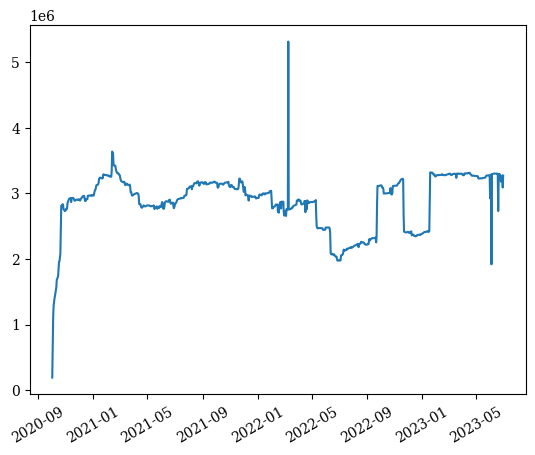

In [10]:
# NOTE: ffill the outlier in feb 2023 to make the plot look nicer
outlier = stkAAVE_supply['BALANCE'].idxmax()
stkAAVE_supply.loc[outlier, 'BALANCE'] = np.nan
stkAAVE_supply = stkAAVE_supply.fillna(method='ffill')
plt.plot(stkAAVE_supply.index, stkAAVE_supply['BALANCE'])
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)  # Rotate and align the tick labels

,timestamp,Deposit rate
date,,
2023-01-27,1.674841e+12,2.800785
2023-01-28,1.674920e+12,1.869347
2023-01-29,1.674997e+12,0.862732
2023-01-30,1.675076e+12,1.632559
2023-01-31,1.675154e+12,1.419575


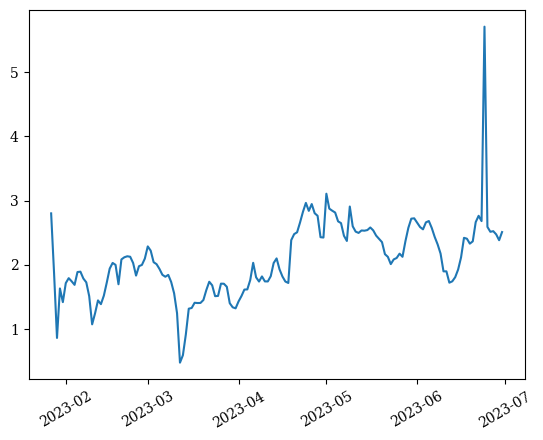

In [11]:
USDC_deposit_rates = pd.read_csv('./data/USDC_deposit_rates.csv', index_col='date')
USDC_deposit_rates.index = pd.to_datetime(USDC_deposit_rates.index).tz_localize(None)
USDC_deposit_rates = USDC_deposit_rates.resample('1d').mean()
display(USDC_deposit_rates.head())
plt.plot(USDC_deposit_rates.index, USDC_deposit_rates['Deposit rate'])
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)  # Rotate and align the tick labels

In [12]:
df = USDC_deposit_rates.join(stkAAVE_supply).join(AAVE_prices)
df = df[['Deposit rate', 'BALANCE', 'Close']].rename({'Deposit rate': 'r_0', 'BALANCE': 'tvl', 'Close': 'price'}, axis=1)
df['r_0'] /= 100
df['R'] = 550*365
df['p'] = 0.3
df['apr'] = df['R'] / df['tvl']
df['r_other'] = 0 # No other risk premia
df['r_slash'] = get_r_slash(df['apr'], df['r_0'], df['r_other'], df['p'])
df['insurance'] = df['tvl'] * df['p']
df['tvl_$'] = df['tvl'] * df['price']
df['savings'] = get_savings(df['r_0'], df['r_other'], df['r_slash'], df['p'], 1, df['R'])
df['savings_$'] = df['savings'] * df['price']
df['R2'] = get_new_R(df['R'], df['p'], 1, df['r_0'], df['r_other'], df['r_slash'])

mean_savings = (df['savings_$']/1e6).mean()
mean_R2 = (df['R2']/365).mean()

In [85]:
print(df['insurance'].mean())
print(df['apr'].mean())
print(df['apr'].std())

978160.4960035847
0.061712577170921226
0.0037445204690556818


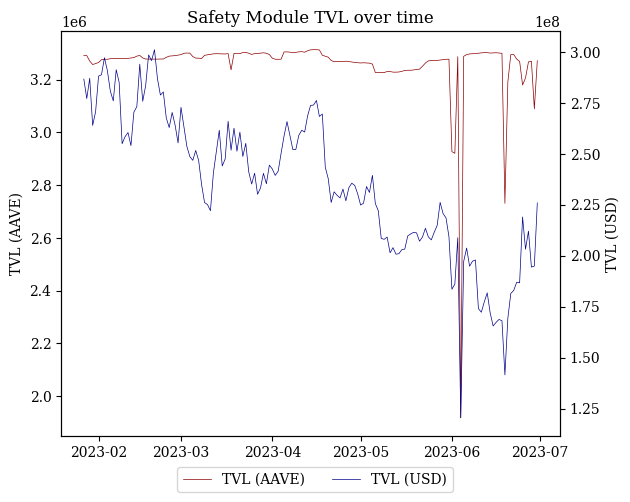

In [13]:
f, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df.index, df['tvl'], color='darkred', linewidth=0.5, label='TVL (AAVE)')
ax2.plot(df.index, df['tvl_$'], color='darkblue', linewidth=0.5, label='TVL (USD)')

ax1.set_ylabel('TVL (AAVE)')
ax2.set_ylabel('TVL (USD)')
ax1.set_title('Safety Module TVL over time')

f.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

f.tight_layout()
f.savefig('./figs/tvl.png', bbox_inches='tight')

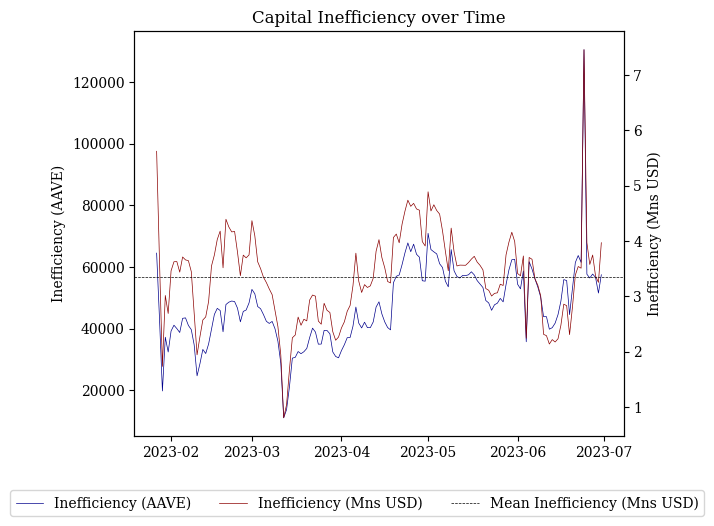

In [14]:
f, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df.index, df['savings'], color='darkblue', linewidth=0.5, label='Inefficiency (AAVE)')
ax2.plot(df.index, df['savings_$']/1e6, color='darkred', linewidth=0.5, label='Inefficiency (Mns USD)')
ax2.axhline(mean_savings, color='black', linewidth=0.5, linestyle='--', label='Mean Inefficiency (Mns USD)')

ax1.set_ylabel('Inefficiency (AAVE)')
ax2.set_ylabel('Inefficiency (Mns USD)')
ax1.set_title('Capital Inefficiency over Time')

f.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
f.tight_layout()
f.savefig('./figs/inefficiency.png', bbox_inches='tight')

In [26]:
print(f"r_0 range: {df['r_0'].min()*100:.2f}%, {df['r_0'].max()*100:.2f}%")
print(f'Average cost savings of ${mean_savings:.2f} Mns USD')
mean_savings_AAVE = 
print(f'Average cost savings of {mean_savings_AAVE}')

r_0 range: 0.48%, 5.71%
Average cost savings of $3.36 Mns USD
Average cost savings of 47364.75409049649


In [28]:
print((df['savings']).quantile(0.25))
print((df['savings']).quantile(0.75))

39636.052481849314
56434.30721689541


In [29]:
print((df['savings_$']).quantile(0.25))
print((df['savings_$']).quantile(0.75))

2818830.2477643266
3791361.563571496


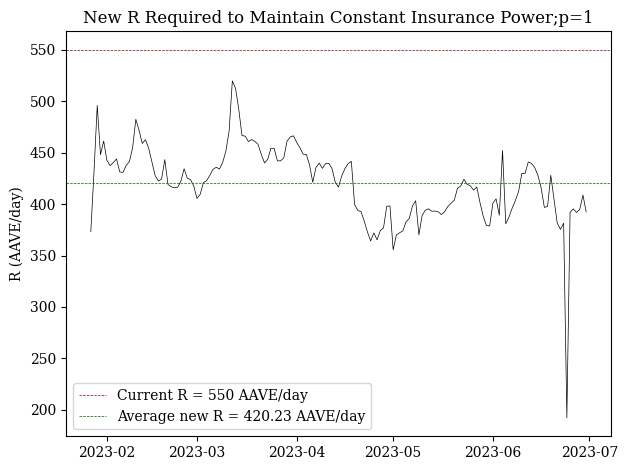

In [16]:
f, ax = plt.subplots()

ax.plot(df.index, df['R2']/365, linewidth=0.5, color='black')
ax.axhline(R1/365, color='darkred', linewidth=0.5, linestyle='--', label='Current R = 550 AAVE/day')
ax.axhline(mean_R2, color='darkgreen', linewidth=0.5, linestyle='--', label=f'Average new R = {mean_R2:.2f} AAVE/day')

ax.set_ylabel('R (AAVE/day)')
ax.set_title('New R Required to Maintain Constant Insurance Power;p=1')
ax.legend()

f.tight_layout()
f.savefig('./figs/new_R_p1.png', bbox_inches='tight')

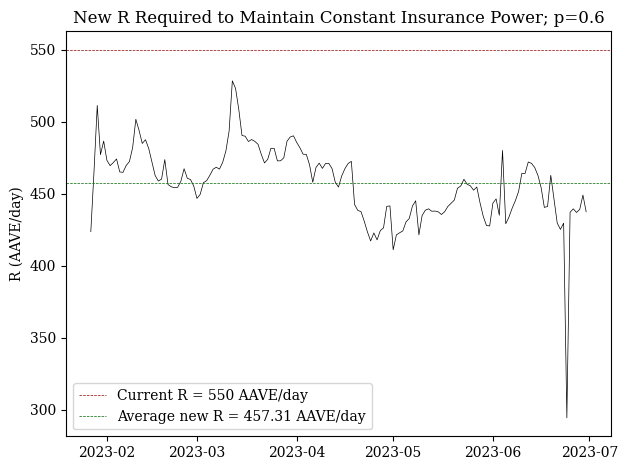

In [17]:
df['R2'] = get_new_R(df['R'], df['p'], 0.6, df['r_0'], df['r_other'], df['r_slash'])
mean_R2 = (df['R2']/365).mean()
q3_R2 = (df['R2']/365).quantile(0.75)

f, ax = plt.subplots()

ax.plot(df.index, df['R2']/365, linewidth=0.5, color='black')
ax.axhline(R1/365, color='darkred', linewidth=0.5, linestyle='--', label='Current R = 550 AAVE/day')
ax.axhline(mean_R2, color='darkgreen', linewidth=0.5, linestyle='--', label=f'Average new R = {mean_R2:.2f} AAVE/day')

ax.set_ylabel('R (AAVE/day)')
ax.set_title('New R Required to Maintain Constant Insurance Power; p=0.6')
ax.legend()

f.tight_layout()
f.savefig('./figs/new_R_p06.png', bbox_inches='tight')

In [18]:
q3_R2

472.4343395658526

In [19]:
AAVE_mean_price = df['price'].mean()
AAVE_mean_price

72.03231525806451

In [20]:
AAVE_mean_price * 401_500

28920974.576112904

In [21]:
df['tvl'].mean()

3260534.986678616

In [22]:
df['r_0'].mean()

0.02079752818762061

In [23]:
df['tvl_$'].mean()

235121997.16252708

In [24]:
df['apr'].mean()

0.061712577170921226